# Libraries & Data

In [5]:
# !pip install numpy
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install lazypredict
# !pip install emoji
!pip install kaggle

### NOTE: Click the Restart runtime button shown in the end of the output.
!pip install -U nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 1.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105123 sha256=5f3b464b2a28d450e2a005b613dbaf74f8bd742bc61ecb3e22184150f31d4103
  Stored in directory: /Users/antonal/Library/Caches/pip/wheels/51/da/0d/fafde33a4df192dee0edadbe6b3a686aa517900001a3c87c9a
Successfully built kaggle

[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [33]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emoji, time, re, kaggle, os, json

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer

from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split, learning_curve, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

In [34]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/antonal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/antonal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antonal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonal/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/antonal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
# Ensure the Kaggle directory exists
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Copy kaggle.json to the right location if it is not already there
# Uncomment and modify the below lines if you need to place your kaggle.json file in the right directory
# import shutil
# shutil.copy('path_to_your_kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))

# Download the dataset using Kaggle API
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
 50%|███████████████████                   | 1.00M/1.99M [00:00<00:00, 1.71MB/s]
100%|██████████████████████████████████████| 1.99M/1.99M [00:00<00:00, 2.94MB/s]


In [20]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"antonal01","key":"3c9b73f51fc2fac05ced2ac9a06dec28"}

with open('/Users/antonal/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/antonal/.kaggle: File exists


In [21]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('twitter-sentiment-analysis2')

In [12]:
!unzip twitter-sentiment-analysis2.zip

Archive:  twitter-sentiment-analysis2.zip
  inflating: test.csv                
  inflating: train.csv               


### Initialise dataset

In [22]:
# Read the CSV file 'train.csv', selecting only the 'Sentiment' and 'SentimentText' columns.
df_tweet_sentiment = pd.read_csv('./train.csv', encoding='ISO-8859-1', usecols=['Sentiment', 'SentimentText'], index_col=False)

# Filtering the DataFrame to get the first 5000 rows where the sentiment is 0 (negative)
df_negative_tweets = df_tweet_sentiment[df_tweet_sentiment['Sentiment'] == 0].head(5000)

# Filtering the DataFrame to get the first 5000 rows where the sentiment is 1 (positive)
df_positive_tweets = df_tweet_sentiment[df_tweet_sentiment['Sentiment'] == 1].head(5000)

# Concatenate the two filtered DataFrames into a single DataFrame
df_tweet_sentiment = pd.concat([df_negative_tweets, df_positive_tweets])

# Shuffle the concatenated DataFrame randomly and reset the index
df_tweet_sentiment = df_tweet_sentiment.sample(frac=1).reset_index(drop=True)
df_tweet_sentiment

,Sentiment,SentimentText
0,1,&quot;We Don't Talk Anymore&quot; by Cliff Ric...
1,0,want to go back to sleep cos its too early bu...
2,1,#Logies Harold better win the Gold Logie haha ...
3,1,"&quot; Become a human transformer, a virtual r..."
4,1,ITS LOUD AGAIN!!!!!
...,...,...
9995,0,Why Twitter will soon become obsolete? http:...
9996,0,I WISH MY BESTIEBYTCH WAS HERE AND NOT DEAD L...
9997,0,might not be able to go to Cali. Maybe Canada...
9998,0,$800 + worth of tupperware covered in mouse po...


In [24]:
# Initialize a WordNetLemmatizer, which is used to reduce words to their base or root form, e.g., (churches -> church, abaci -> abacus)
lemmatizer = WordNetLemmatizer()

# Initialize a PerceptronTagger, which is a part-of-speech tagger used to label words with their corresponding parts of speech
tagger = PerceptronTagger()

# Initialize a TweetTokenizer, which is specifically designed to handle tokenizing tweets (short text with special characters and emoticons)
tweet_wt = TweetTokenizer()

# Preprocess dataset

In [25]:
# Lemmatization helper function
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [26]:
def replace_special_tokens(sequence):
    # Replace URLs with the token "<url>"
    sequence = re.sub(
        """http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]
        [0-9a-fA-F]))+""",
        "<url>",
        sequence,
    )

    # Replace mentions (words starting with @) with the token "<user>"
    sequence = re.sub("@\S+", "<user>", sequence)

    # Replace hashtags (words starting with #) with the token "<hashtag>"
    sequence = re.sub("#\S+", "<hashtag>", sequence)

    # Replace numbers (including decimals) with the token "<number>"
    sequence = re.sub("([+-]?([0-9]+([.][0-9]*)?|[.][0-9]+))", "<number>", sequence)

    # Convert emojis to text representation (e.g., 😊 to :smiling_face_with_smiling_eyes:)
    sequence = emoji.demojize(sequence) # remove emojis

    # Remove emoticons (represented as :word:) from the sequence
    sequence = re.sub(r'\s*:[\w]+', ' ', sequence) # remove emoticons

    # Convert the entire sequence to lowercase
    sequence = sequence.lower()

    return sequence

In [27]:
# Apply the replace_special_tokens function to the 'SentimentText' column to preprocess the text
df_tweet_sentiment["processed_text"] = df_tweet_sentiment["SentimentText"].apply(replace_special_tokens)

# Tokenize the processed text using the TweetTokenizer
df_tweet_sentiment["tokenized_text"] = df_tweet_sentiment["processed_text"].apply(lambda x: tweet_wt.tokenize(x))

# Tag the tokenized text with part-of-speech tags using the PerceptronTagger
df_tweet_sentiment["text_tags"] = df_tweet_sentiment["tokenized_text"].apply(lambda x: tagger.tag(x))
df_tweet_sentiment

,Sentiment,SentimentText,processed_text,tokenized_text,text_tags
0,1,&quot;We Don't Talk Anymore&quot; by Cliff Ric...,&quot;we don't talk anymore&quot; by cliff ric...,"["", we, don't, talk, anymore, "", by, cliff, ri...","[("", NN), (we, PRP), (don't, VBP), (talk, VB),..."
1,0,want to go back to sleep cos its too early bu...,want to go back to sleep cos its too early bu...,"[want, to, go, back, to, sleep, cos, its, too,...","[(want, NN), (to, TO), (go, VB), (back, RB), (..."
2,1,#Logies Harold better win the Gold Logie haha ...,<hashtag> harold better win the gold logie hah...,"[<hashtag>, harold, better, win, the, gold, lo...","[(<hashtag>, NN), (harold, NN), (better, RBR),..."
3,1,"&quot; Become a human transformer, a virtual r...","&quot; become a human transformer, a virtual r...","["", become, a, human, transformer, ,, a, virtu...","[("", JJ), (become, VB), (a, DT), (human, JJ), ..."
4,1,ITS LOUD AGAIN!!!!!,its loud again!!!!!,"[its, loud, again, !, !, !]","[(its, PRP$), (loud, NN), (again, RB), (!, .),..."
...,...,...,...,...,...
9995,0,Why Twitter will soon become obsolete? http:...,why twitter will soon become obsolete? <url>,"[why, twitter, will, soon, become, obsolete, ?...","[(why, WRB), (twitter, NN), (will, MD), (soon,..."
9996,0,I WISH MY BESTIEBYTCH WAS HERE AND NOT DEAD L...,i wish my bestiebytch was here and not dead l...,"[i, wish, my, bestiebytch, was, here, and, not...","[(i, NN), (wish, VBP), (my, PRP$), (bestiebytc..."
9997,0,might not be able to go to Cali. Maybe Canada...,might not be able to go to cali. maybe canada...,"[might, not, be, able, to, go, to, cali, ., ma...","[(might, MD), (not, RB), (be, VB), (able, JJ),..."
9998,0,$800 + worth of tupperware covered in mouse po...,$<number> + worth of tupperware covered in mou...,"[$, <number>, +, worth, of, tupperware, covere...","[($, $), (<number>, CD), (+, NNP), (worth, NN)..."


In [28]:
# Function to lemmatize a sequence of tokens with POS tags
def lemma(sequence):
  return [lemmatizer.lemmatize(token,pos=nltk_pos_tagger(pos_tag))\
     if nltk_pos_tagger(pos_tag) != None else lemmatizer.lemmatize(token)\
     for token, pos_tag in sequence]

In [29]:
# Apply the lemma function to the 'text_tags' column of the dataframe
# 'text_tags' is assumed to be a list of (token, pos_tag) tuples for each tweet
df_tweet_sentiment['lemmatized_text'] = df_tweet_sentiment['text_tags'].apply(lambda x: lemma(x))

In [30]:
# Apply a lambda function to the 'lemmatized_text' column of the dataframe
# This lambda function joins the list of lemmatized tokens into a single string
# Each token is separated by a space
df_tweet_sentiment['lemmatized_text_joined'] = df_tweet_sentiment['lemmatized_text'].apply(lambda x: " ".join(x))
df_tweet_sentiment

,Sentiment,SentimentText,processed_text,tokenized_text,text_tags,lemmatized_text,lemmatized_text_joined
0,1,&quot;We Don't Talk Anymore&quot; by Cliff Ric...,&quot;we don't talk anymore&quot; by cliff ric...,"["", we, don't, talk, anymore, "", by, cliff, ri...","[("", NN), (we, PRP), (don't, VBP), (talk, VB),...","["", we, don't, talk, anymore, "", by, cliff, ri...",""" we don't talk anymore "" by cliff richard - <..."
1,0,want to go back to sleep cos its too early bu...,want to go back to sleep cos its too early bu...,"[want, to, go, back, to, sleep, cos, its, too,...","[(want, NN), (to, TO), (go, VB), (back, RB), (...","[want, to, go, back, to, sleep, co, it, too, e...",want to go back to sleep co it too early but i...
2,1,#Logies Harold better win the Gold Logie haha ...,<hashtag> harold better win the gold logie hah...,"[<hashtag>, harold, better, win, the, gold, lo...","[(<hashtag>, NN), (harold, NN), (better, RBR),...","[<hashtag>, harold, well, win, the, gold, logi...",<hashtag> harold well win the gold logie haha ...
3,1,"&quot; Become a human transformer, a virtual r...","&quot; become a human transformer, a virtual r...","["", become, a, human, transformer, ,, a, virtu...","[("", JJ), (become, VB), (a, DT), (human, JJ), ...","["", become, a, human, transformer, ,, a, virtu...",""" become a human transformer , a virtual route..."
4,1,ITS LOUD AGAIN!!!!!,its loud again!!!!!,"[its, loud, again, !, !, !]","[(its, PRP$), (loud, NN), (again, RB), (!, .),...","[it, loud, again, !, !, !]",it loud again ! ! !
...,...,...,...,...,...,...,...
9995,0,Why Twitter will soon become obsolete? http:...,why twitter will soon become obsolete? <url>,"[why, twitter, will, soon, become, obsolete, ?...","[(why, WRB), (twitter, NN), (will, MD), (soon,...","[why, twitter, will, soon, become, obsolete, ?...",why twitter will soon become obsolete ? <url>
9996,0,I WISH MY BESTIEBYTCH WAS HERE AND NOT DEAD L...,i wish my bestiebytch was here and not dead l...,"[i, wish, my, bestiebytch, was, here, and, not...","[(i, NN), (wish, VBP), (my, PRP$), (bestiebytc...","[i, wish, my, bestiebytch, be, here, and, not,...",i wish my bestiebytch be here and not dead lea...
9997,0,might not be able to go to Cali. Maybe Canada...,might not be able to go to cali. maybe canada...,"[might, not, be, able, to, go, to, cali, ., ma...","[(might, MD), (not, RB), (be, VB), (able, JJ),...","[might, not, be, able, to, go, to, cali, ., ma...",might not be able to go to cali . maybe canada...
9998,0,$800 + worth of tupperware covered in mouse po...,$<number> + worth of tupperware covered in mou...,"[$, <number>, +, worth, of, tupperware, covere...","[($, $), (<number>, CD), (+, NNP), (worth, NN)...","[$, <number>, +, worth, of, tupperware, cover,...",$ <number> + worth of tupperware cover in mous...


In [31]:
x_train, x_test, y_train, y_test = train_test_split(df_tweet_sentiment['lemmatized_text_joined'], df_tweet_sentiment['Sentiment'], test_size=0.2,
                                                    random_state=23828748)
print('Training texts:', len(x_train))
print('Testing texts:', len(x_test))

Training texts: 8000
Testing texts: 2000


# TF-Idf Vectorizer

In [35]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words = stopwords.words('english'))

In [37]:
# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

print(vectorizer.get_feature_names_out()[:10])

['abit' 'able' 'able get' 'absolutely' 'abt' 'ac' 'accent' 'access'
 'accident' 'account']


In [38]:
print('Shape of training data: {}'.format(x_train_tfidf.shape))
print('Shape of test data: {}\n'.format(x_test_tfidf.shape))

# sparse matrix --> Saves only the cells where tf*idf is not zero
print(type(x_test_tfidf))
print(x_test_tfidf[0, :])

Shape of training data: (8000, 5000)
Shape of test data: (2000, 5000)

<class 'scipy.sparse._csr.csr_matrix'>
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 829)	0.26676739288272644
  (0, 843)	0.5631390987318052
  (0, 879)	0.5315467034061816
  (0, 2967)	0.3225650448088938
  (0, 4633)	0.2459741399745931
  (0, 4635)	0.4057291337866921


# Baseline

In [39]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

Training took: 0.005434989929199219 seconds 



In [40]:
# Evaluate
predictions = baseline.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

Train accuracy: 50.26%
Test accuracy: 48.95% 

#Class 0 in Train dataset: (3979,)
#Class 1 in Train dataset: (4021,)


In [41]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3979
           1       0.50      1.00      0.67      4021

    accuracy                           0.50      8000
   macro avg       0.25      0.50      0.33      8000
weighted avg       0.25      0.50      0.34      8000



/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1021
           1       0.49      1.00      0.66       979

    accuracy                           0.49      2000
   macro avg       0.24      0.50      0.33      2000
weighted avg       0.24      0.49      0.32      2000



/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Confusion Matrix for test data:


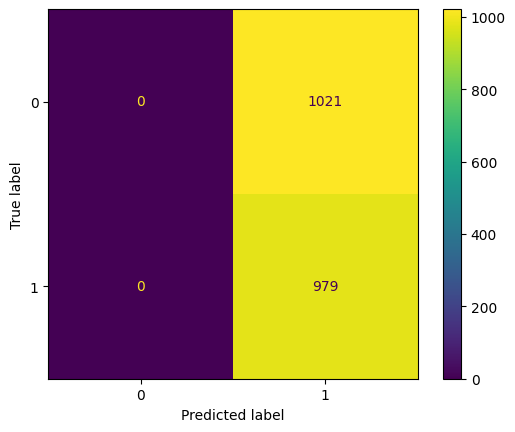

In [43]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(baseline, x_test_tfidf, y_test, values_format = '.0f')

# Naive Bayess

In [44]:
# Train
clf = MultinomialNB()  # you can also use Gaussian Naive Bayes
start_time = time.time()
clf.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

Training took: 0.006302833557128906 seconds 



In [45]:
# Evaluate
predictions = clf.predict(x_train_tfidf)
score = f1_score(y_train,predictions)
print("Train f1-score: {:.2f}%".format(score*100))

Train f1-score: 84.99%


In [46]:
predictions_test = clf.predict(x_test_tfidf)
score = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

Test f1-score: 72.70% 



In [49]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3979
           1       0.85      0.85      0.85      4021

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In [48]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      1021
           1       0.73      0.72      0.73       979

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000




Confusion Matrix for test data:


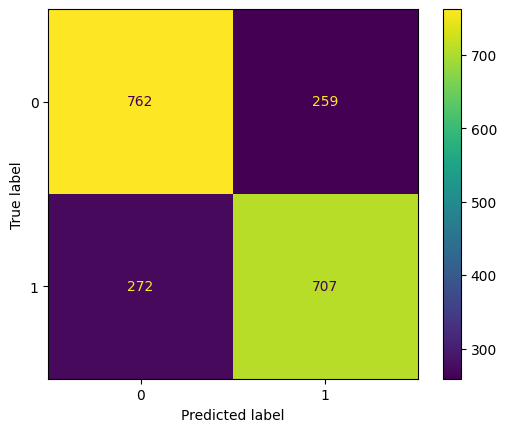

In [50]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(clf, x_test_tfidf, y_test, values_format = '.0f')

# Naive Bayess with cross-validation

In [51]:
# Train
clf = MultinomialNB()  # you can also use Gaussian Naive Bayes
start_time = time.time()

In [53]:
scores = cross_val_score(clf, x_train_tfidf, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [0.73     0.736875 0.751875 0.721875 0.745   ]
Average cross-validation score: 0.737125


In [54]:
cross_val_predictions = cross_val_predict(clf, x_train_tfidf, y_train, cv=5)
cross_val_scores = f1_score(y_train,cross_val_predictions)
print("Cross validation train f1-score: {:.2f}%".format(cross_val_scores*100))

Cross validation train f1-score: 73.68%


In [55]:
cross_val_predictions_test = cross_val_predict(clf, x_test_tfidf, y_test, cv=5)
score = f1_score(y_test, cross_val_predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

Test f1-score: 67.50% 



In [56]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, cross_val_predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74      3979
           1       0.74      0.73      0.74      4021

    accuracy                           0.74      8000
   macro avg       0.74      0.74      0.74      8000
weighted avg       0.74      0.74      0.74      8000



In [60]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, cross_val_predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1021
           1       0.69      0.66      0.67       979

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000




Confusion Matrix for test data:


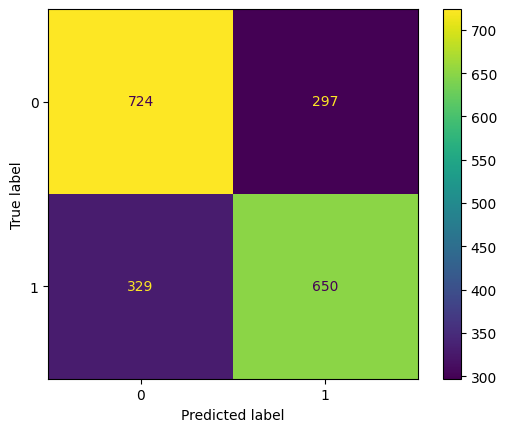

In [59]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_predictions(y_test, cross_val_predictions_test, values_format = '.0f')

# Naive Bayes with dimensionality reduction / because SVD gets negative values we can use SVD with SVC model for classification

# Logistic Regression

In [61]:
# Train
# Solver -- Algorithm to use in the optimization problem.
clf = LogisticRegression(solver="liblinear")
start_time = time.time()
clf.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

Training took: 0.02649688720703125 seconds 



In [62]:
# Evaluate
predictions = clf.predict(x_train_tfidf)
score = f1_score(y_train, predictions)
print("Train f1-score: {:.2f}%".format(score*100))

Train f1-score: 85.52%


In [63]:
predictions_test = clf.predict(x_test_tfidf)
score = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

Test f1-score: 73.43% 



In [64]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      3979
           1       0.86      0.85      0.86      4021

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



In [65]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1021
           1       0.74      0.73      0.73       979

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000




Confusion Matrix for test data:


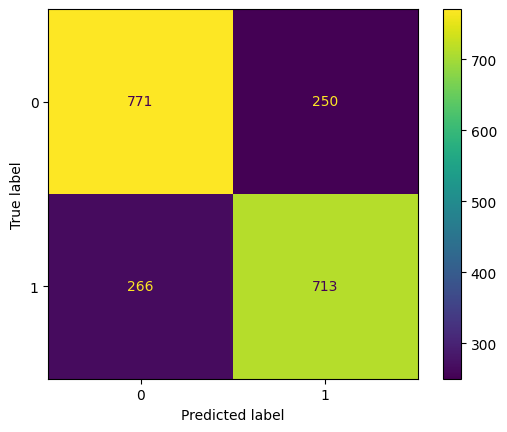

In [66]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(clf, x_test_tfidf, y_test, values_format = '.0f')

# Logistic Regression with Cross Validation

In [67]:
#Cross Validation Logistic Regression
# Fit the model with CV
log_cv = LogisticRegressionCV(cv=5, random_state=2).fit(x_train_tfidf, y_train)# Score
log_cv.score(x_test_tfidf,y_test)

0.7335

In [69]:
predictions = log_cv.predict(x_train_tfidf)
score = f1_score(y_train, predictions)

print("Train f1-score: {:.2f}% \n".format(score*100))

Train f1-score: 88.86% 



In [70]:
predictions_test = log_cv.predict(x_test_tfidf)
score_pred = f1_score(y_test, predictions_test)

print("Test f1-score: {:.2f}% \n".format(score_pred*100))

Test f1-score: 72.79% 



In [71]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3979
           1       0.89      0.89      0.89      4021

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



In [72]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1021
           1       0.73      0.73      0.73       979

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000




Confusion Matrix for test data:


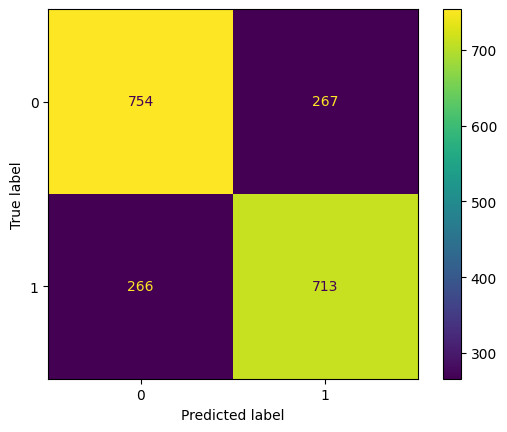

In [73]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(log_cv, x_test_tfidf, y_test, values_format = '.0f')



# MLP

In [74]:
clf = MLPClassifier(solver='adam', hidden_layer_sizes=(100, 100),
                    early_stopping=True, random_state=123456)

In [75]:
scores = cross_val_score(clf, x_train_tfidf, y_train, cv=5)
# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [0.735625 0.7125   0.75375  0.741875 0.76375 ]
Average cross-validation score: 0.7415


In [76]:
cross_val_predictions = cross_val_predict(clf, x_train_tfidf, y_train, cv=5)
cross_val_scores = f1_score(y_train,cross_val_predictions)
print("Cross validation train f1-score: {:.2f}%".format(cross_val_scores*100))

Cross validation train f1-score: 73.68%


In [77]:
cross_val_predictions_test = cross_val_predict(clf, x_test_tfidf, y_test, cv=5)
score = f1_score(y_test, cross_val_predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

Test f1-score: 66.00% 



In [78]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3979
           1       0.89      0.89      0.89      4021

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



In [79]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))


Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1021
           1       0.73      0.73      0.73       979

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000




Confusion Matrix for test data:


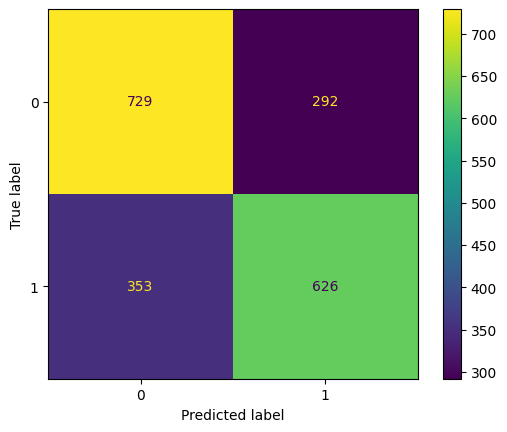

In [80]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_predictions(y_test, cross_val_predictions_test, values_format = '.0f')

# k-NN


In [82]:
# Train
clf = KNeighborsClassifier(n_neighbors=5)
start_time = time.time()
clf.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

Training took: 0.003370046615600586 seconds 



In [83]:
# Evaluate
predictions = clf.predict(x_train_tfidf)
score = f1_score(y_train,predictions)
print("Train f1-score: {:.2f}%".format(score*100))

Train f1-score: 62.03%


In [84]:
predictions_test = clf.predict(x_test_tfidf)
score = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

Test f1-score: 43.40% 



In [85]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75      3979
           1       0.85      0.49      0.62      4021

    accuracy                           0.70      8000
   macro avg       0.74      0.70      0.69      8000
weighted avg       0.74      0.70      0.68      8000



In [86]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.56      0.83      0.67      1021
           1       0.65      0.33      0.43       979

    accuracy                           0.58      2000
   macro avg       0.61      0.58      0.55      2000
weighted avg       0.61      0.58      0.56      2000




Confusion Matrix for test data:


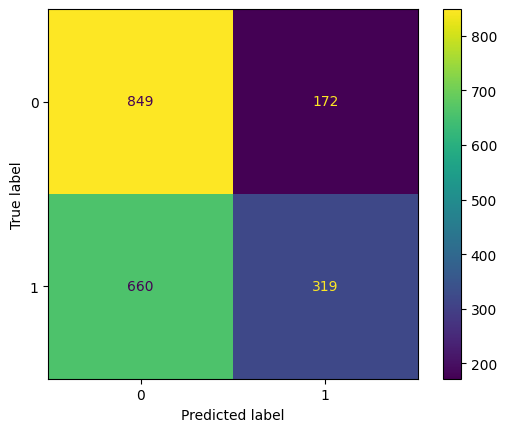

In [87]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(clf, x_test_tfidf, y_test, values_format = '.0f')

# k-NN with cross-validation

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
start_time = time.time()

In [88]:
scores = cross_val_score(clf, x_train_tfidf, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [0.554375 0.55875  0.553125 0.554375 0.55875 ]
Average cross-validation score: 0.5558749999999999


In [89]:
cross_val_predictions = cross_val_predict(clf, x_train_tfidf, y_train, cv=5)
cross_val_scores = f1_score(y_train,cross_val_predictions)
print("Cross validation train f1-score: {:.2f}%".format(cross_val_scores*100))

Cross validation train f1-score: 38.39%


In [90]:
cross_val_predictions_test = cross_val_predict(clf, x_test_tfidf, y_test, cv=5)
score = f1_score(y_test, cross_val_predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

Test f1-score: 37.52% 



In [91]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, cross_val_predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.53      0.84      0.65      3979
           1       0.63      0.28      0.38      4021

    accuracy                           0.56      8000
   macro avg       0.58      0.56      0.52      8000
weighted avg       0.58      0.56      0.52      8000



In [92]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, cross_val_predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.53      0.79      0.64      1021
           1       0.56      0.28      0.38       979

    accuracy                           0.54      2000
   macro avg       0.55      0.54      0.51      2000
weighted avg       0.55      0.54      0.51      2000




Confusion Matrix for test data:


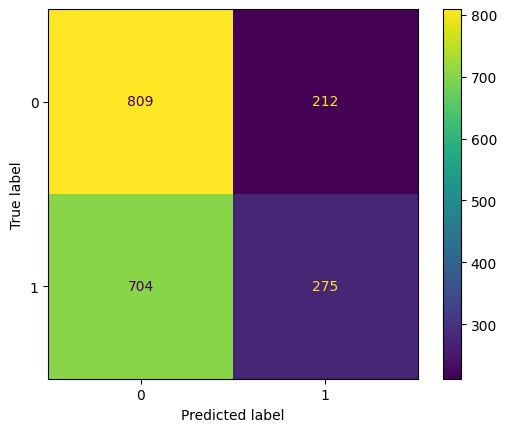

In [93]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_predictions(y_test, cross_val_predictions_test, values_format = '.0f')

# SVC classifier with SVD-REDUCTION

we will use SVD for the reduction of the features, and we will use the SVC classification model

In [94]:
svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(x_train_tfidf)
X_test_svd = svd.transform(x_test_tfidf)

In [95]:
svd_dimred_clf = svm.SVC(kernel='linear')
#svd_dimred_clf.fit(X_train_svd, y_train)

scores = cross_val_score(svd_dimred_clf, X_train_svd, y_train, cv=5)
# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [0.74     0.73125  0.755625 0.74375  0.75    ]
Average cross-validation score: 0.7441249999999999


In [96]:
cross_val_predictions = cross_val_predict(svd_dimred_clf, X_train_svd, y_train, cv=5)
cross_val_scores = f1_score(y_train,cross_val_predictions)
print("Cross validation train f1-score: {:.2f}%".format(cross_val_scores*100))

Cross validation train f1-score: 74.49%


In [97]:
cross_val_predictions_test = cross_val_predict(svd_dimred_clf, X_test_svd, y_test, cv=5)
score = f1_score(y_test, cross_val_predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

Test f1-score: 66.77% 



In [98]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, cross_val_predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3979
           1       0.75      0.74      0.74      4021

    accuracy                           0.74      8000
   macro avg       0.74      0.74      0.74      8000
weighted avg       0.74      0.74      0.74      8000



In [99]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, cross_val_predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1021
           1       0.70      0.64      0.67       979

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



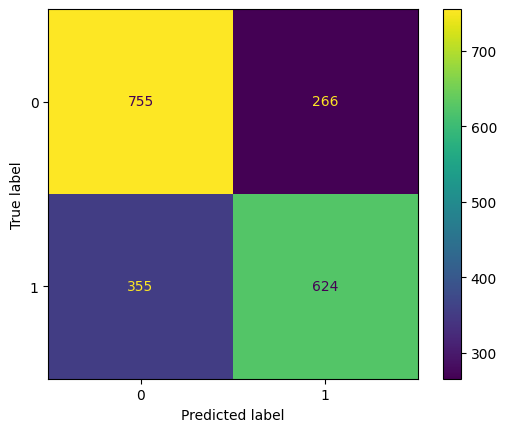

In [100]:
ConfusionMatrixDisplay.from_predictions(y_test, cross_val_predictions_test, values_format = '.0f')

# Hyper parameter tuning with GridSearch

For each classifier we used above we have the following f1-scores (using cross-validation)

NB:Test f1-score: 70.98%
LG:Test f1-score: 74.92%
SVD:Test f1-score: 71.74%
MLP:Test f1-score: 68.93%
k-nn:Test f1-score: 66.91%

we can see that the 2 best are Logistic Regression and SVC with SVD Reduction.So we will tune the hyper parameter of logistic regression

Hyper parameter tuning


In [ ]:
lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegressionCV())])

In [ ]:
# The larger the grid the more time it will take
# If too slow consider to connect with local runtime. See instructions in the link:
# https://research.google.com/colaboratory/local-runtimes.html
# Starting Jupyter inside a virtual env like anaconda is highly recommended

grid_params = {
  'lr__solver': ['liblinear'],
  'lr__Cs': list(range(1, 10)),
  'lr__cv': [3, 5, 10],
  'lr__penalty':['l1', 'l2'],
  'tfidf_vectorizer__ngram_range': [(1,1), (1,2), (1, 3)],
  'tfidf_vectorizer__max_features':[2000,3000,5000] ,
  'tfidf_vectorizer__sublinear_tf': [True, False]
}

clf = GridSearchCV(lr_pipeline, grid_params, scoring='f1', verbose=10)
start_time = time.time()
clf.fit(x_train, y_train)
print("GridSearchCV took: {} seconds \n".format(time.time() - start_time))

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 2 folds for each of 972 candidates, totalling 1944 fits
[CV 1/2; 1/972] START lr__Cs=1, lr__cv=3, lr__penalty=l1, lr__solver=liblinear, tfidf_vectorizer__max_features=2000, tfidf_vectorizer__ngram_range=(1, 1), tfidf_vectorizer__sublinear_tf=True
[CV 1/2; 1/972] END lr__Cs=1, lr__cv=3, lr__penalty=l1, lr__solver=liblinear, tfidf_vectorizer__max_features=2000, tfidf_vectorizer__ngram_range=(1, 1), tfidf_vectorizer__sublinear_tf=True;, score=0.000 total time=   0.2s
[CV 2/2; 1/972] START lr__Cs=1, lr__cv=3, lr__penalty=l1, lr__solver=liblinear, tfidf_vectorizer__max_features=2000, tfidf_vectorizer__ngram_range=(1, 1), tfidf_vectorizer__sublinear_tf=True
[CV 2/2; 1/972] END lr__Cs=1, lr__cv=3, lr__penalty=l1, lr__solver=liblinear, tfidf_vectorizer__max_features=2000, tfidf_vectorizer__ngram_range=(1, 1), tfidf_vectorizer__sublinear_tf=True;, score=0.000 total time=   0.3s
[CV 1/2; 2/972] START lr__Cs=1, lr__cv=3, lr__penalty=l1, lr__solver=liblinear, tfidf_vectorizer__max_features

After they hyper parameter tuning .The logistic Regression Classifier is

In [ ]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
)

In [ ]:
# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf_tuned = vectorizer.fit_transform(x_train)
x_test_tfidf_tuned = vectorizer.transform(x_test)

print(vectorizer.get_feature_names_out()[:100])

['able' 'able to' 'about' 'about it' 'about my' 'about number' 'about the'
 'about this' 'about to' 'about you' 'above' 'abt' 'accident' 'accord'
 'accord to' 'account' 'ache' 'across' 'act' 'act like' 'action'
 'actually' 'ad' 'adam' 'add' 'add me' 'add to' 'addict' 'admit' 'adopt'
 'advice' 'afford' 'afraid' 'afraid to' 'after' 'after number' 'after the'
 'afternoon' 'again' 'against' 'age' 'ago' 'agree' 'ah' 'ahead' 'ahh'
 'ahhh' 'aim' 'ain' 'aint' 'air' 'air france' 'airport' 'aka' 'ala' 'alan'
 'alarm' 'album' 'alcohol' 'alive' 'all' 'all be' 'all by' 'all day'
 'all do' 'all have' 'all my' 'all need' 'all number' 'all of' 'all over'
 'all round' 'all should' 'all that' 'all the' 'all this' 'all those'
 'all time' 'all want' 'all you' 'allow' 'almost' 'almost number' 'alone'
 'along' 'alot' 'alot of' 'already' 'alright' 'also' 'also have'
 'although' 'always' 'always be' 'always make' 'amaze' 'amazing' 'america'
 'an' 'an amazing']


Train f1-score: 90.38% 

Test f1-score: 76.94% 

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4017
           1       0.91      0.90      0.90      3983

    accuracy                           0.90      8000
   macro avg       0.90      0.90      0.90      8000
weighted avg       0.90      0.90      0.90      8000

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       983
           1       0.79      0.75      0.77      1017

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000


Confusion Matrix for test data:


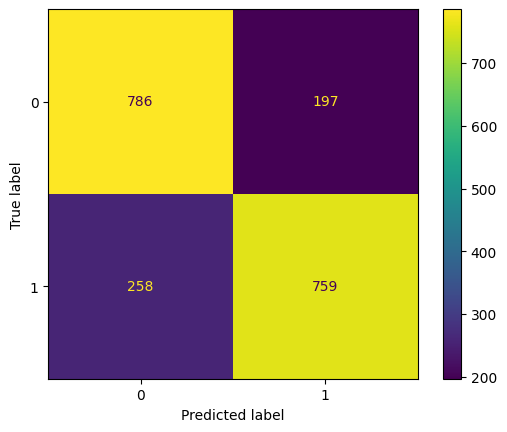

In [ ]:
#Cross Validation Logistic Regression
# Fit the model with CV
log_cv = LogisticRegressionCV(cv=3, Cs=8, random_state=2,penalty='l2',solver='liblinear').fit(x_train_tfidf_tuned, y_train)# Score
log_cv.score(x_test_tfidf_tuned,y_test)

predictions = log_cv.predict(x_train_tfidf_tuned)
score = f1_score(y_train, predictions)

predictions_test = log_cv.predict(x_test_tfidf_tuned)
score_pred = f1_score(y_test, predictions_test)

print("Train f1-score: {:.2f}% \n".format(score*100))
print("Test f1-score: {:.2f}% \n".format(score_pred*100))

print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))



print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(log_cv, x_test_tfidf_tuned, y_test, values_format = '.0f')

# Learning Curves

From the code from the labs we have the following

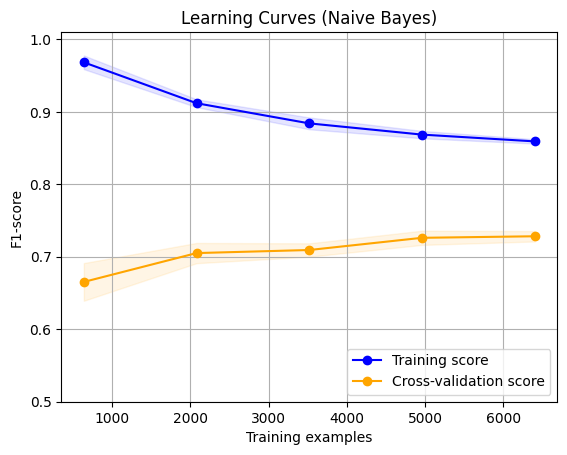

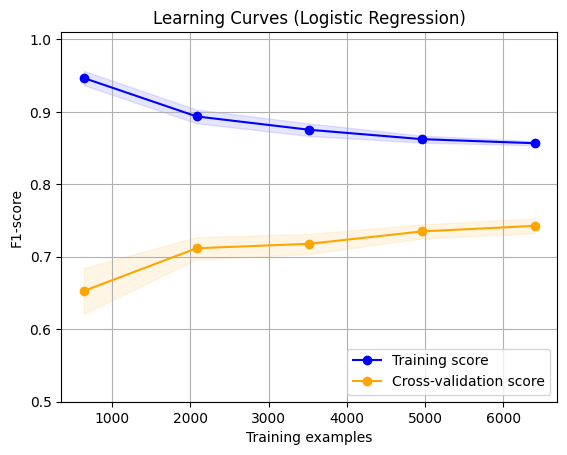

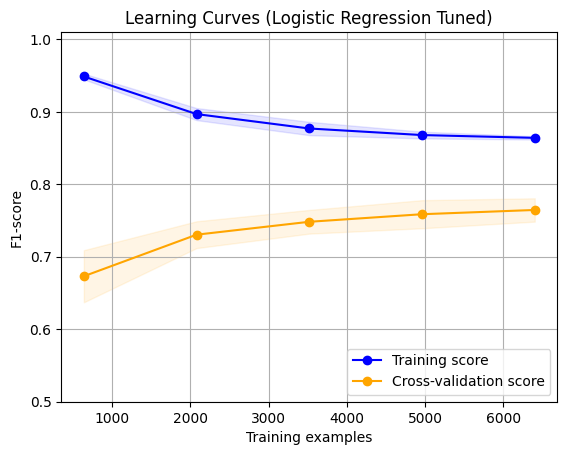

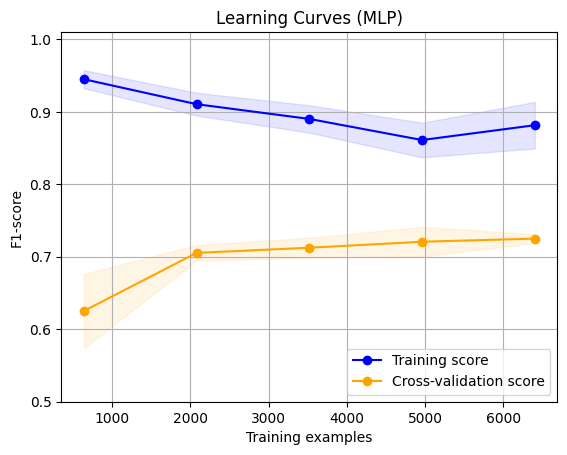

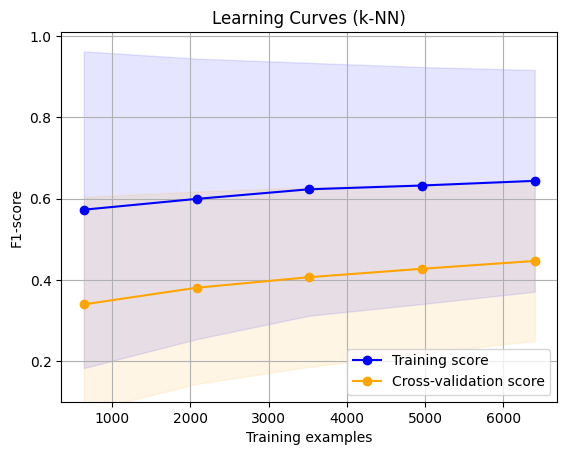

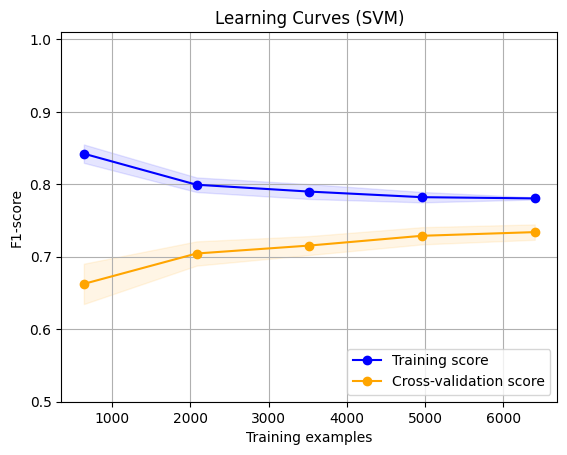

In [ ]:
# Learning curves with cross-validtion
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1',
        train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt


# x, y = x_train_tfidf, y_train
# Use cross validation with 5 splits, 20% test subset size each time
title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = MultinomialNB()
plot_learning_curve(estimator, title, x_train_tfidf, y_train,
                    ylim=(0.5, 1.01), cv=cv, n_jobs=-1)
plt.show()

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, x_train_tfidf, y_train,
                    ylim=(0.5, 1.01), cv=cv, n_jobs=-1)
plt.show()

title = "Learning Curves (Logistic Regression Tuned)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, x_train_tfidf_tuned, y_train,
                    ylim=(0.5, 1.01), cv=cv, n_jobs=-1)
plt.show()


title = "Learning Curves (MLP)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = MLPClassifier(solver='adam', hidden_layer_sizes=(100, 100),
                    early_stopping=True, random_state=123456)
plot_learning_curve(estimator, title, x_train_tfidf, y_train,
                    ylim=(0.5, 1.01), cv=cv, n_jobs=-1)
plt.show()

title = "Learning Curves (k-NN)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(n_neighbors=5)
plot_learning_curve(estimator, title, x_train_tfidf, y_train,
                    ylim=(0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()

title = "Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = svm.SVC(kernel='linear')
plot_learning_curve(estimator, title, X_train_svd, y_train,
                    ylim=(0.5, 1.01), cv=cv, n_jobs=-1)
plt.show()



# Precision-Recall curves

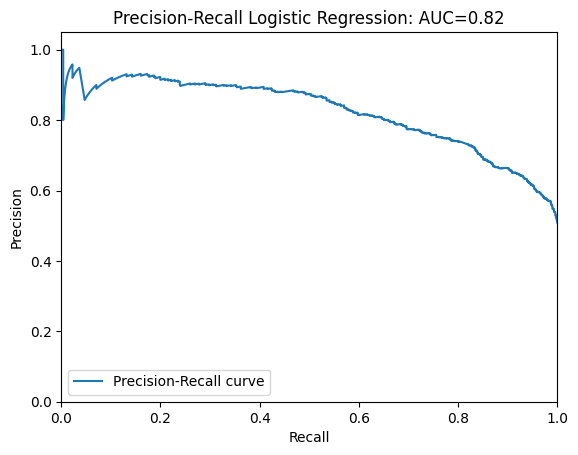

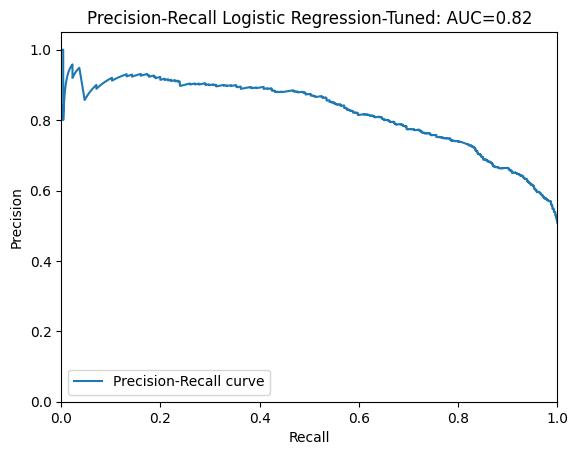

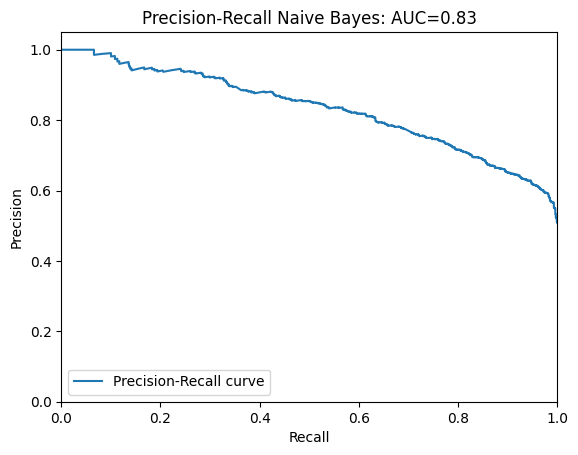

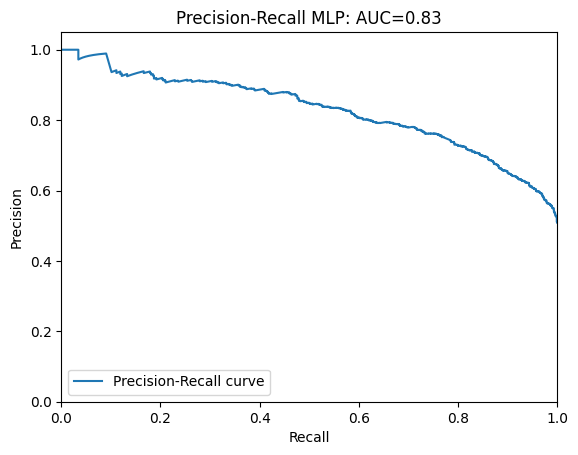

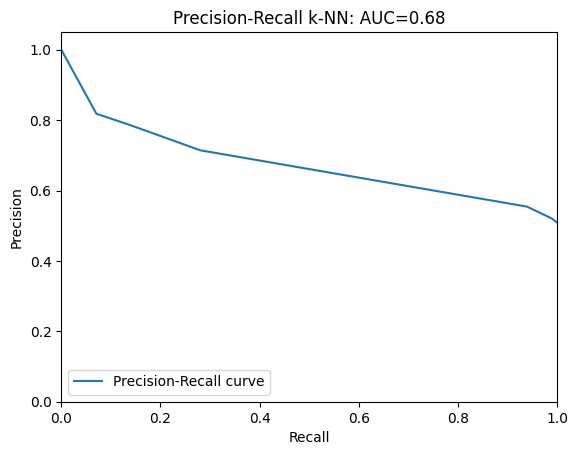

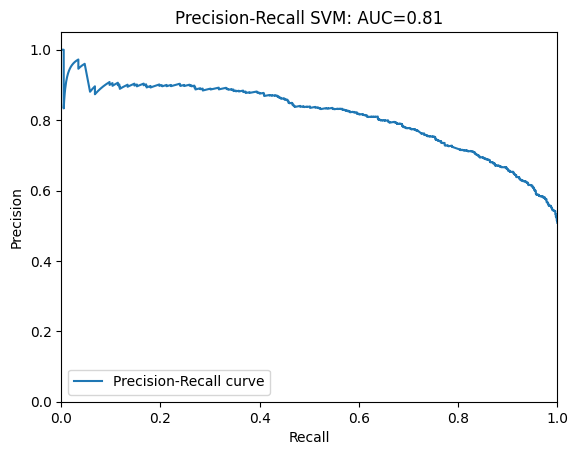

In [ ]:
# Precision-Recall curves

# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')
estimators = {'Logistic Regression':LogisticRegression(solver='liblinear'),
              'Logistic Regression-Tuned':LogisticRegression(solver='liblinear'),#MORE FROM GRID
              'Naive Bayes':MultinomialNB(),
              'MLP':MLPClassifier(solver='adam', hidden_layer_sizes=(100, 100),
                    early_stopping=True, random_state=123456),
              'k-NN':KNeighborsClassifier(n_neighbors=5),
              'SVM':svm.SVC(kernel='linear',probability=True)
              }

for (name,estimator) in estimators.items():
    model = estimator
    model.fit(x_train_tfidf, y_train)
    # We use the probabilities because the precision_recall_curve function needs them
    pred = model.predict_proba(x_test_tfidf)
    # model.predict() returns outputs of 0 or 1
    # model.predict_proba() returns an array: [P(x=0), P(x=1)]

    precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
    area = auc(recall, precision)

    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
    plt.legend(loc="lower left")
    plt.show()